Compare trained model weights with and without noise matrix.

Compare and visualize all weights in both models.

- trained at 2 different $f_p$: [0.1, 0.9]

Things to viz / quantify:

- performances across feature_probs
- onehot input-output heatmap (in=1, in=-1)
- input-output response curves
- condition number of effective targets
- singular value spectra of effective targets

In [1]:
"""Notebook settings and imports."""

%load_ext autoreload
%autoreload 2
# %flow mode reactive

import os

from collections import defaultdict
from dataclasses import dataclass, field
from typing import Callable, List, Optional, Tuple, Union

import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
import torch as t

from einops import asnumpy, einsum, rearrange, reduce, repeat, pack, parse_shape, unpack
from einops.layers.torch import Rearrange, Reduce
from jaxtyping import Float, Int
from matplotlib import pyplot as plt
from matplotlib import ticker as mticker
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from plotly import express as px
from plotly import graph_objects as go
from plotly import io as pio
from rich import print as rprint
from scipy.stats import describe, kstest, mannwhitneyu, sem
from torch import nn, optim, Tensor
from torch.nn import functional as F
from tqdm.notebook import tqdm

from toy_cis.models import CisConfig, Cis
from toy_cis import plot, util

In [2]:
"""Set KMP_DUPLICATE_LIB_OK=TRUE to avoid MKL errors when plotting with mpl"""

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
plt.rcParams.update({"font.size": 14})

In [3]:
"""Set torch device."""

# device = t.device("cpu")  # small toy models may be faster via cpu
device = t.device("cuda" if t.cuda.is_available() else "cpu")
device_name = t.cuda.get_device_name(0) if t.cuda.is_available() else "cpu"
print(f"{device_name=}")

device_name='NVIDIA GeForce RTX 3090'


In [4]:
sns.set_style("whitegrid")

plt.rcParams.update({"font.size": 14})
plt.rcParams["axes.titlesize"] = 18
plt.rcParams["axes.labelsize"] = 16
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["legend.title_fontsize"] = 13

In [46]:
np.exp(- (1/2 * np.log(1/2)) * 2)

np.float64(2.0)

## Training the models

In [5]:
"""Create functions for generating batches, loss, and training."""

def gen_batch(
    model: Cis,
    batch_sz: int, 
    sparsity: float | Float[Tensor, "inst feat"],
    device: t.device,
    target: str = "relu+x"
) -> (
    tuple[Float[Tensor, "batch inst feat"], Float[Tensor, "batch inst feat"]]
):
    """Generates a batch of x, y data."""
    # Randomly generate features vals, and for each, randomly set which samples are non-zero
    x = t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) * 2 - 1  # [-1, 1]
    is_active = (
        t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) < (1 - sparsity)
    )
    x *= is_active
    if target == "relu+x":
        return x, t.relu(x) + x
    elif target == "relu":
        return x, t.relu(x)
    else:
        raise ValueError(f"Unknown target: {target}")

def loss_fn(y, y_true, i):
    return reduce((y - y_true) ** 2 * i, "batch inst feat -> ", "mean")

def train(
    model: Cis,
    batch_sz: int,
    feat_sparsity: float | Float[Tensor, "inst feat"],
    feat_importance: float | Float[Tensor, "inst feat"],
    loss_fn: Callable,
    optimizer: optim.Optimizer,
    n_steps: int,
    logging_freq: int,
    device: t.device,
    target: str = "relu+x"
) -> List[Float]:
    """Trains the model for `n_steps` steps, logging loss every `logging_freq` steps."""    
    losses = []

    pbar = tqdm(range(n_steps), desc="Training")
    for step in pbar:
        x, y_true = gen_batch(model, batch_sz, feat_sparsity, device, target)
        y = model.forward(x)
        loss = loss_fn(y, y_true, feat_importance)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Log progress
        if step % logging_freq == 0 or (step + 1 == n_steps):
            losses.append(loss.item())
            pbar.set_postfix({"loss": f"{loss.item():.6f}"})
    
    return losses

@t.no_grad()
def eval_model(
    model: Cis, 
    batch_sz: int,
    feat_sparsity: float | Float[Tensor, "inst feat"],
    n_batches: int,
    device: t.device,
    target: str = "relu+x",
):
    losses = t.zeros(n_batches)
    
    for b in range(n_batches):
        x, y_true = gen_batch(model, batch_sz, feat_sparsity, device, target)
        y = model.forward(x)
        losses[b] = loss_fn(y, y_true, 1)
    
    return losses

In [7]:
"""Set up and train models."""

feat_sparsity = 0.9
feat_prob = 1 - feat_sparsity
layer_act_fns = [t.relu, lambda x: x]
batch_sz = 128
n_steps = 3000
logging_freq = n_steps // 10
n_feat=2
n_hidden=1

# target_integral = 5/3  # 5/3 is integral of (relu(x) + x)**2 from -1 to 1
target_integral = 1/3  # 1/3 is integral of (relu(x))**2 from -1 to 1
interval_length = 2
naive_loss = target_integral / interval_length * ((n_feat - n_hidden) / n_feat) * feat_prob
print(f"naive loss: {naive_loss:.2e}")

naive loss: 8.33e-03


### no residual

In [8]:
cis_simple_cfg = CisConfig(
    n_instances=1,
    n_feat=2,
    n_hidden=1,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
)
cis_simple = Cis(cis_simple_cfg, device=device).to(device)
optimizer = optim.Adam(cis_simple.parameters(), lr=1e-3)
_losses = train(
    model=cis_simple,
    batch_sz=batch_sz,
    feat_sparsity=feat_sparsity,
    feat_importance=1.0,
    loss_fn=loss_fn,
    optimizer=optimizer,
    n_steps=n_steps,
    logging_freq=logging_freq,
    device=device,
    target="relu",
)


Training:   0%|          | 0/3000 [00:00<?, ?it/s]

In [9]:
eval_losses = eval_model(
    cis_simple, 
    batch_sz=10000,
    feat_sparsity=feat_sparsity,
    n_batches=100,
    device=device,
    target="relu",
)
print(f"eval loss: {eval_losses.mean().item():.2e}")

eval loss: 8.28e-03


### residual w/noise

In [114]:
# noise_params = {
#     "matrix_type": "symmetric",
#     "noise_coeff": 0.2,
#     "learned": True,
# }

noise_params = {
    "matrix_type": "rank-r",
    "r": 1,
    "noise_coeff": 0.2,
    "learned": True,
}

cis_simple_sym_cfg = CisConfig(
    n_instances=1,
    n_feat=2,
    n_hidden=1,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
    skip_cnx=True,
    noise_params=noise_params,
)
cis_simple_sym = Cis(cis_simple_sym_cfg, device=device).to(device)
optimizer = optim.Adam(cis_simple_sym.parameters(), lr=1e-3)
_losses = train(
    model=cis_simple_sym,
    batch_sz=batch_sz,
    feat_sparsity=feat_sparsity,
    feat_importance=1.0,
    loss_fn=loss_fn,
    optimizer=optimizer,
    n_steps=n_steps,
    logging_freq=logging_freq,
    device=device,
)


Training:   0%|          | 0/3000 [00:00<?, ?it/s]

In [115]:
eval_losses = eval_model(
    cis_simple_sym, 
    batch_sz=100000,  # 1000000 
    feat_sparsity=feat_sparsity,
    n_batches=100,
    device=device
)
print(f"eval loss: {eval_losses.mean().item():.2e}")

eval loss: 5.42e-03


In [108]:
print(cis_simple_sym.noise_coeff)
print(cis_simple_sym.noise_base)

Parameter containing:
tensor(0.7066, device='cuda:0', requires_grad=True)
tensor([[[ 0.0000, -0.2665],
         [-0.2665,  0.0000]]], device='cuda:0')


## Model Viz

In [116]:
models = [cis_simple, cis_simple_sym]
model_names = ["relu", "relu+x_sym"]
targets = ["relu", "relu+x"]

### p=0.1

#### Performance across feature_probs

Testing across feature sparsities: 100%|██████████| 19/19 [00:01<00:00, 14.51it/s]


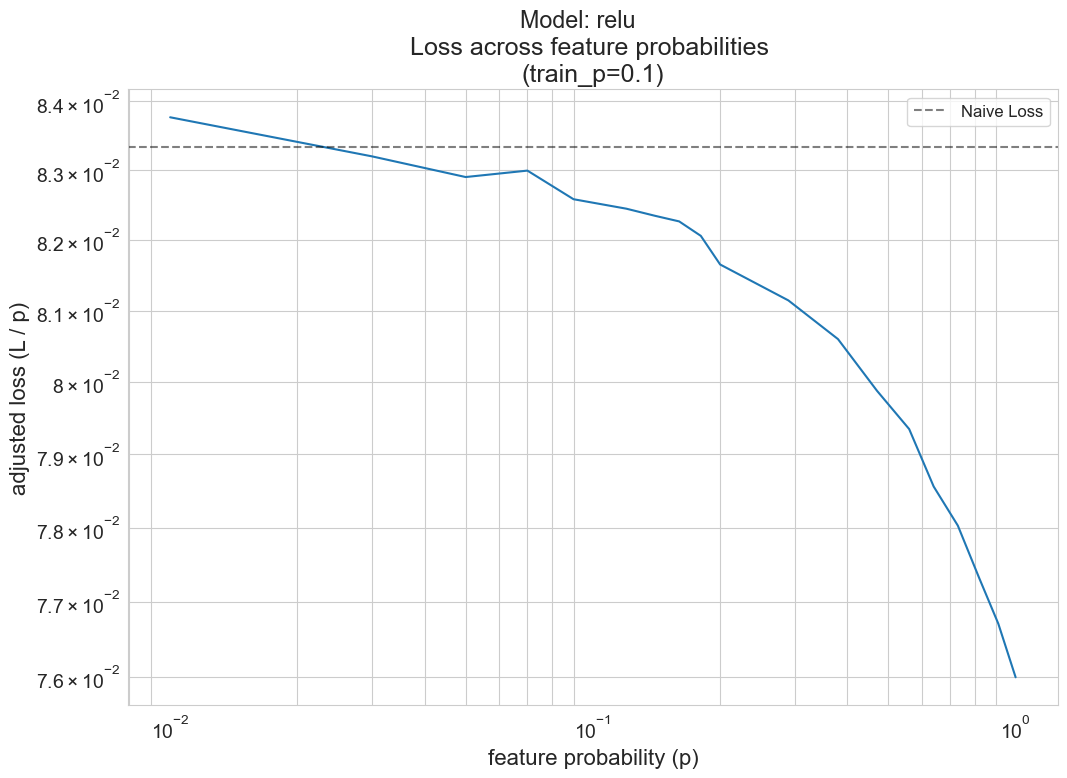

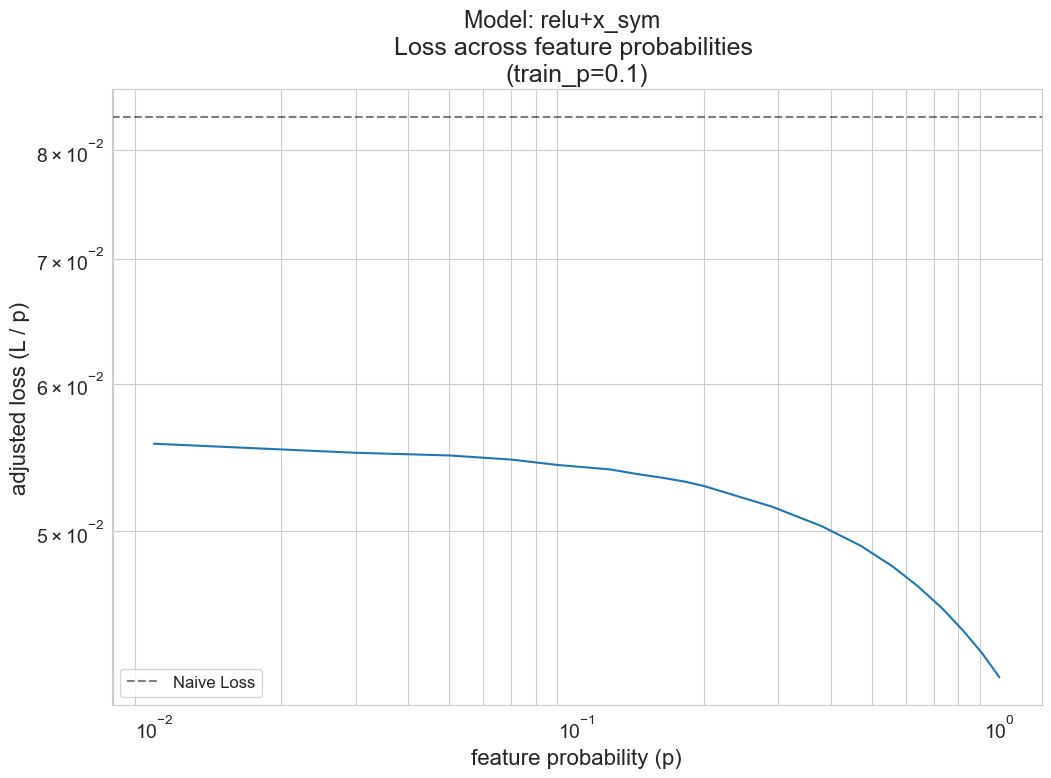

In [14]:
sparsity_low = np.round(np.linspace(0.0, 0.8, 10), 2)
sparsity_high = np.round(np.linspace(0.8, 0.99, 10), 2)
sparsities = np.unique(np.concatenate((sparsity_low,sparsity_high)))

for model, name, target in zip(models, model_names, targets, strict=True):
    ax, _ = plot.plot_loss_across_sparsities(
        sparsities=sparsities,
        model=model,
        eval_model=eval_model,
        target=target,
        train_sparsity=feat_sparsity,
    )
    ax.figure.suptitle(f"Model: {name}")
    ax.grid(which="both", axis="both")

#### Input-Output


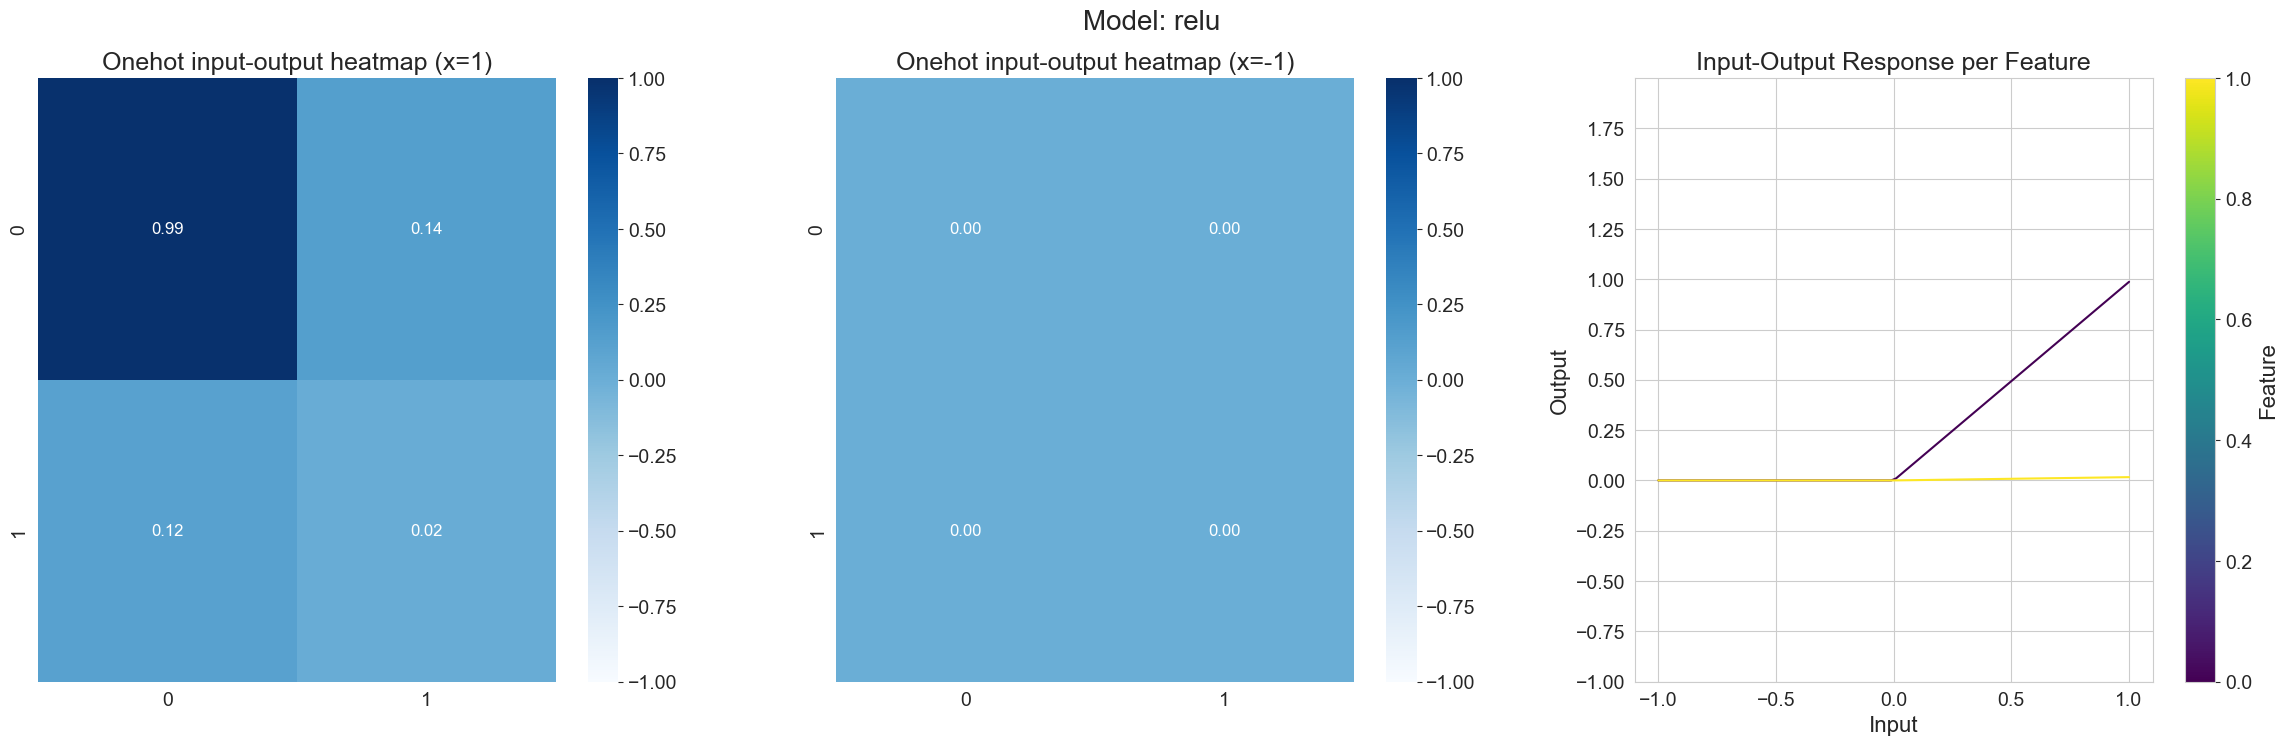

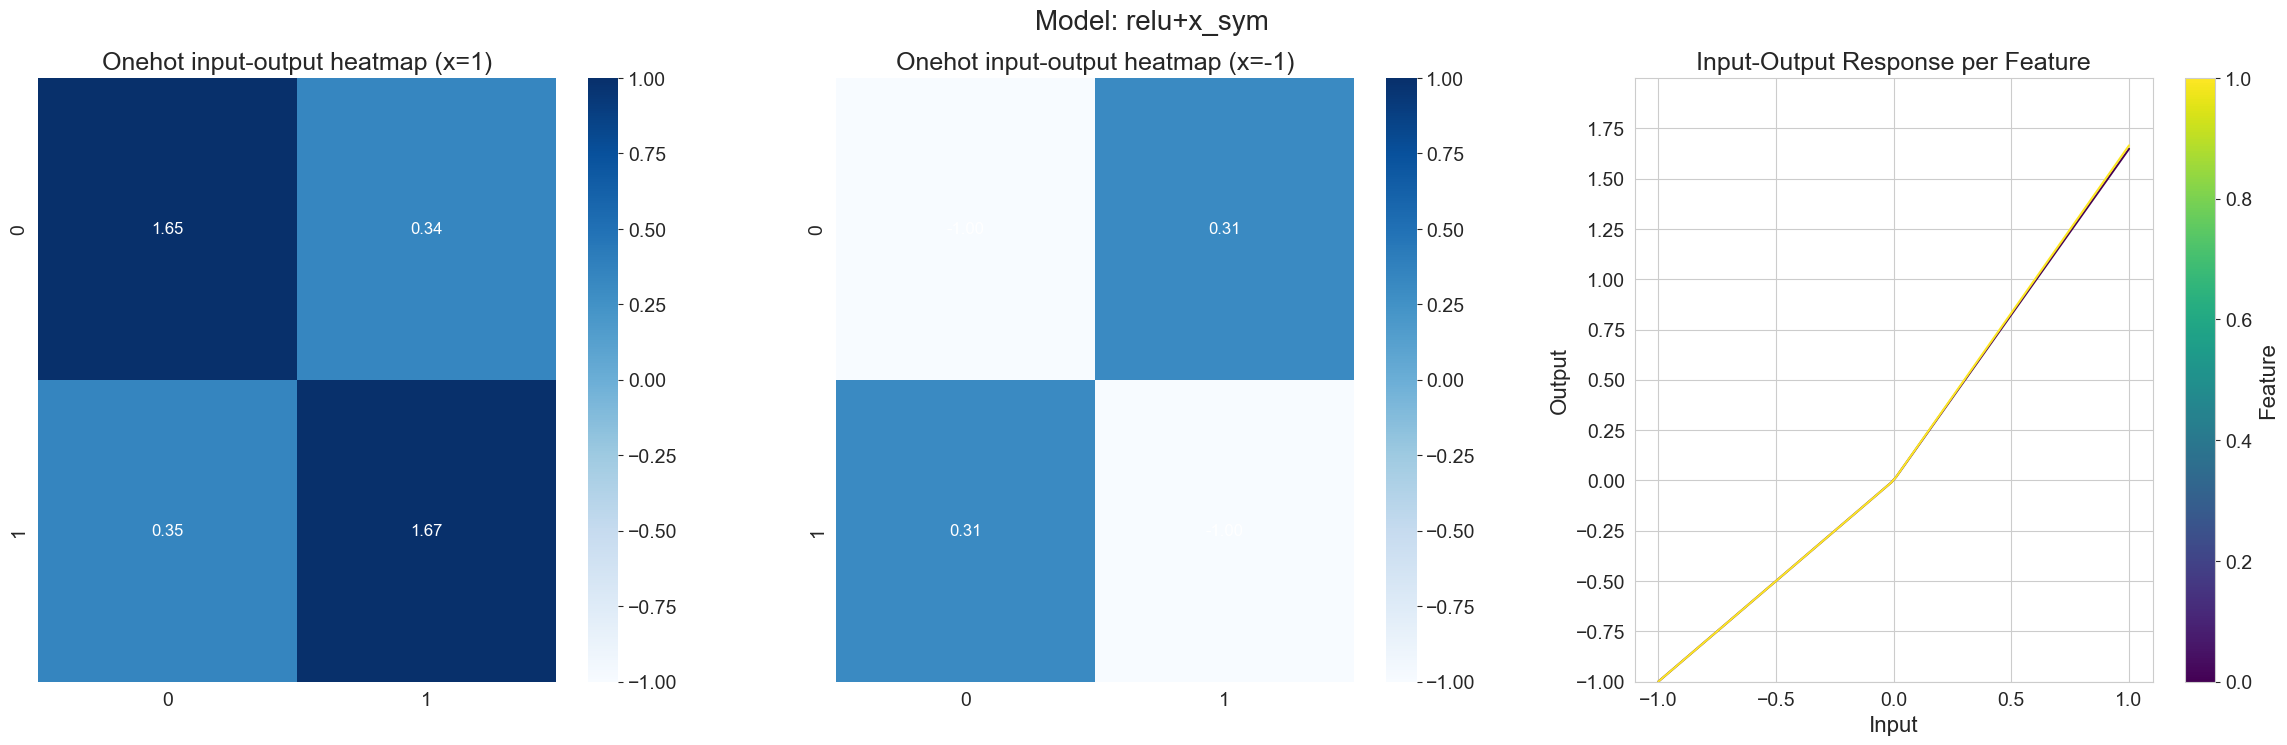

In [117]:
for model, model_name in zip(models, model_names):
    fig, axs = plt.subplots(1, 3, figsize=(24, 8))
    
    plot.plot_input_output_heatmap(1, model, ax=axs[0], annot=True, cmap="Blues")
    plot.plot_input_output_heatmap(-1, model, ax=axs[1], annot=True, cmap="Blues")
    x = t.linspace(-1, 1, 100, device=device)
    Y = util.in_out_response(model, x, device=device)
    plot.plot_input_output_response(Y, x, list(range(model.cfg.n_feat)), ax=axs[2])
    axs[2].set_ylim(-1, 2)
    axs[2].set_yticks(np.arange(-1, 2, 0.25))

    
    fig.tight_layout(pad=3)
    fig.suptitle(f"Model: {model_name}", fontsize=20)

#### Weights


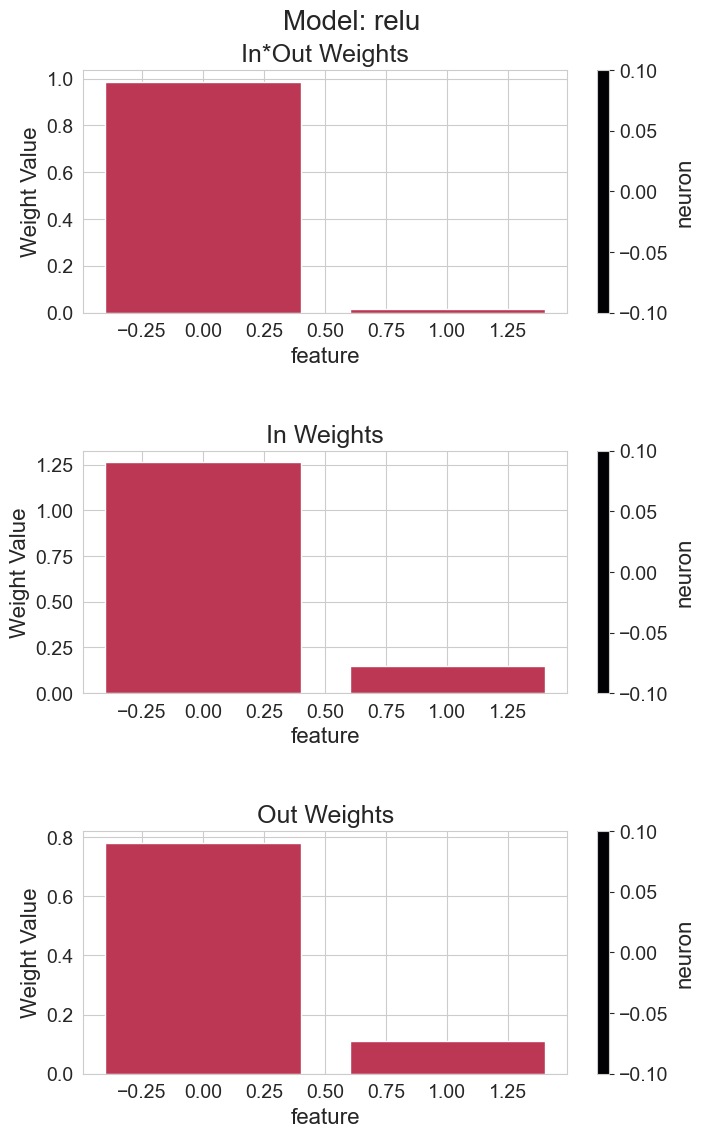

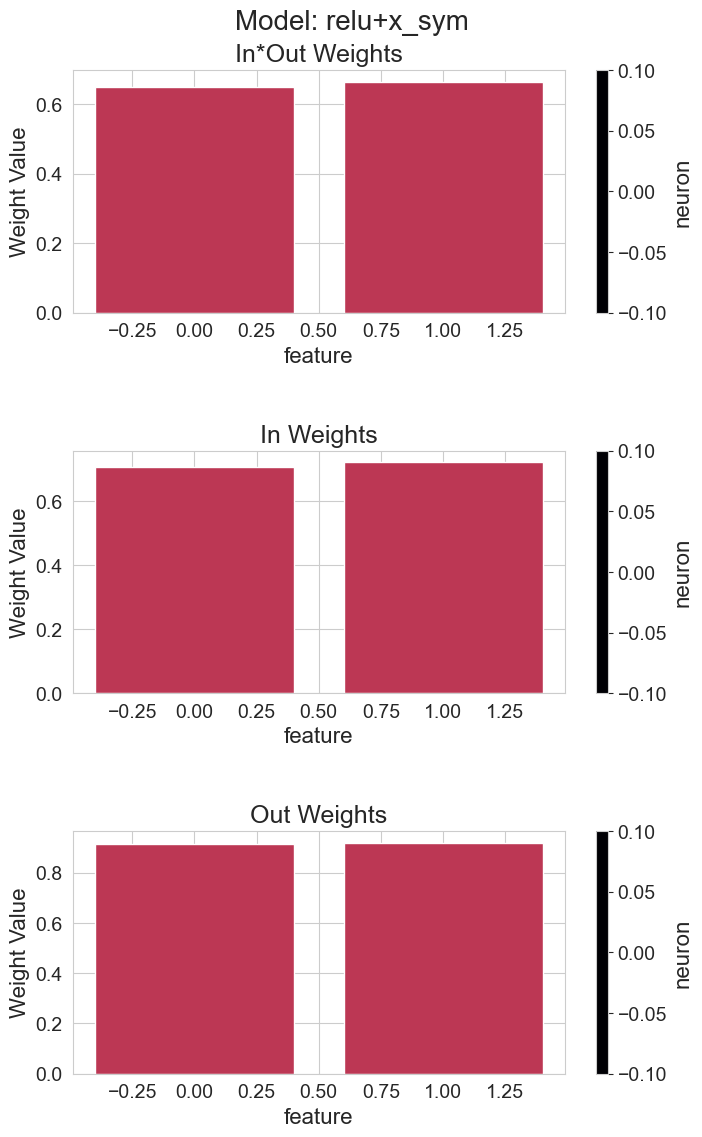

In [118]:
for model, model_name in zip(models, model_names):
    fig, axs = plt.subplots(3, 1, figsize=(8, 12))
    W_adj = einsum(model.W1, model.W2, "inst dmlp feat, inst feat dmlp -> dmlp feat")
    W_adj = util.threshold_matrix(W_adj, threshold=0.001)
    plot.plot_weight_bars(W_adj, xax="feature", ax=axs[0])
    axs[0].set_title("In*Out Weights")
    plot.plot_weight_bars(
        util.threshold_matrix(model.W1[0], threshold=0.001), xax="feature", ax=axs[1]
    )
    axs[1].set_title("In Weights")
    plot.plot_weight_bars(
        util.threshold_matrix(model.W2[0].T, threshold=0.001), xax="feature", ax=axs[2]
    )
    axs[2].set_title("Out Weights")

    fig.tight_layout(pad=3)
    fig.suptitle(f"Model: {model_name}", fontsize=20)

In [156]:
model.Wn.data[0], model.W1.data[0], model.W2.data[0]

(tensor([[ 1.0000, -0.1536],
         [-0.1536,  1.0000]], device='cuda:0'),
 tensor([[0.7842, 0.3412]], device='cuda:0'),
 tensor([[1.1753],
         [0.4464]], device='cuda:0'))

In [311]:
cis_simple_sym.Wn.data, cis_simple_sym.W1.data, cis_simple_sym.W2.data

(tensor([[[1.0000, 0.0539],
          [0.0539, 1.0000]]], device='cuda:0'),
 tensor([[[0.6000, 0.6000]]], device='cuda:0'),
 tensor([[[1.],
          [1.]]], device='cuda:0'))

In [91]:
model.Wn.data[0], model.W1.data[0], model.W2.data[0]

(tensor([[ 1.0000, -0.2123],
         [-0.2123,  1.0000]], device='cuda:0'),
 tensor([[0.6030, 0.6125]], device='cuda:0'),
 tensor([[0.9891],
         [1.0144]], device='cuda:0'))

#### Condition number and Singular Value spectra of $r(x)$

In [15]:
sns.set_style("white")

In [143]:
x, relu_x = gen_batch(models[0], 1024, feat_sparsity, device)
relu_x_k = np.linalg.cond(asnumpy(relu_x.squeeze())).item()
print(f"{relu_x_k=:.3f}")
relu_sv = t.linalg.svdvals(relu_x.squeeze()).sort(descending=True).values
sv_dict = {"relu": relu_sv}

for model, model_name in zip(models[:-2], model_names[:-2]):
    # Get residual target values (res_target) for a test batch
    Wnx = einsum(model.Wn, x, "inst feat feat_out, batch inst feat -> batch inst feat_out")
    res_target = relu_x - Wnx
    
    # Get condition number of residual target.. 
    res_target_k = np.linalg.cond(asnumpy(res_target.squeeze())).item()
    print(f"{res_target_k=:.3f} : {model_name=}")

    # Get singular values of residual target.
    res_sv = t.linalg.svdvals(res_target.squeeze()).sort(descending=True).values
    sv_dict[model_name] = res_sv


relu_x_k=1.807
res_target_k=1.968 : model_name='asym-norm'
res_target_k=2.402 : model_name='sym-norm'
res_target_k=2.463 : model_name='rank-r-10'
res_target_k=11.097 : model_name='rank-r-2'


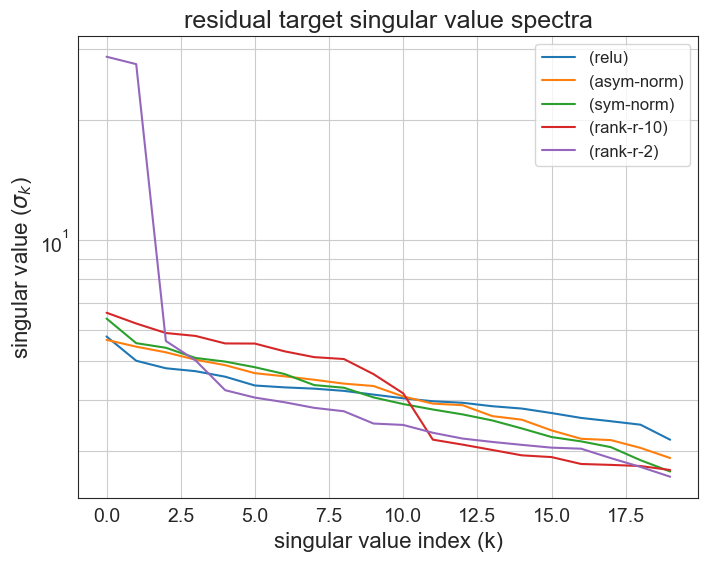

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for i, (model_name, sv_values) in enumerate(sv_dict.items()):
    ax.semilogy(
        asnumpy(sv_values), 
        label=f"({model_name})",
        # linestyle=linestyles[i % len(linestyles)],
        # color=colors[i % len(colors)]
    )

ax.set_xlabel("singular value index (k)")
ax.set_ylabel(r"singular value ($\sigma_k$)")
ax.set_title("residual target singular value spectra")
ax.legend()
ax.grid(which="both", axis="both")

# Expectation: steeper decay of singular values = effectively lower rank = easier to learn

#### Dot-products of $W_2$ neurons with $W_n$ eigenvectors


In [146]:
projs

tensor([[0.1091, 0.1396, 0.0352, 0.0211, 0.0235, 0.0299, 0.0817, 0.1111, 0.0028,
         0.0668],
        [0.1858, 0.0556, 0.0400, 0.1626, 0.1459, 0.1102, 0.0681, 0.1393, 0.1670,
         0.1030],
        [0.0907, 0.1290, 0.0409, 0.0464, 0.0717, 0.0933, 0.0728, 0.0810, 0.3083,
         0.0396],
        [0.0863, 0.0179, 0.0517, 0.0652, 0.0395, 0.0760, 0.3499, 0.0604, 0.2279,
         0.0713],
        [0.0997, 0.1059, 0.2747, 0.0645, 0.0091, 0.2440, 0.0187, 0.0055, 0.0622,
         0.0193],
        [0.0480, 0.2414, 0.0717, 0.0372, 0.2178, 0.0431, 0.0126, 0.0847, 0.3558,
         0.1776],
        [0.3149, 0.1039, 0.1178, 0.3196, 0.1105, 0.0922, 0.0653, 0.2470, 0.2265,
         0.0137],
        [0.3158, 0.1576, 0.1008, 0.5105, 0.1893, 0.0192, 0.0011, 0.3303, 0.0275,
         0.1889],
        [0.0681, 0.2368, 0.0398, 0.2127, 0.1630, 0.0475, 0.2088, 0.1565, 0.1429,
         0.3319],
        [0.3014, 0.0928, 0.0035, 0.1090, 0.3311, 0.2353, 0.6624, 0.2031, 0.0980,
         0.1694],
        [0

In [152]:
U

tensor([[-0.2283-0.1326j, -0.2283+0.1326j, -0.0626+0.0580j, -0.0626-0.0580j,
          0.0492-0.0406j,  0.0492+0.0406j,  0.2292-0.1895j,  0.2292+0.1895j,
         -0.4326+0.0000j, -0.4326-0.0000j, -0.4571+0.0878j, -0.4571-0.0878j,
         -0.1575+0.0978j, -0.1575-0.0978j,  0.0823+0.1377j,  0.0823-0.1377j,
          0.0916+0.0000j,  0.1919+0.0000j,  0.0903+0.0000j, -0.1695+0.0000j],
        [ 0.0309-0.0984j,  0.0309+0.0984j,  0.1757+0.1290j,  0.1757-0.1290j,
         -0.0069+0.0635j, -0.0069-0.0635j, -0.0937-0.1189j, -0.0937+0.1189j,
          0.0773-0.1612j,  0.0773+0.1612j,  0.0303+0.0190j,  0.0303-0.0190j,
         -0.2009+0.1550j, -0.2009-0.1550j,  0.1360+0.0104j,  0.1360-0.0104j,
         -0.1428+0.0000j,  0.0747+0.0000j, -0.0437+0.0000j, -0.0370+0.0000j],
        [ 0.0031-0.2410j,  0.0031+0.2410j, -0.1157+0.0306j, -0.1157-0.0306j,
         -0.1640+0.0866j, -0.1640-0.0866j,  0.1556-0.1118j,  0.1556+0.1118j,
         -0.1273-0.0840j, -0.1273+0.0840j, -0.1463+0.0394j, -0.1463-0.0394

In [151]:
projs

tensor([[1.9288e+00, 5.1331e-02, 3.3304e-02, 2.8534e-03, 1.2134e+00, 3.3536e-03,
         1.3251e-01, 2.9125e-02, 7.0411e-03, 1.2477e-02],
        [3.3233e-02, 2.5538e-02, 1.5664e-01, 1.4783e-02, 3.6500e-02, 4.6922e-04,
         1.1237e+00, 4.4129e-01, 1.6967e-01, 9.4035e-03],
        [1.2846e-02, 8.8180e-02, 7.4493e-01, 1.6754e-03, 1.7424e-02, 1.0851e-02,
         2.5205e-01, 6.3770e-02, 2.4868e-01, 1.7211e-03],
        [3.2910e-01, 2.5063e-02, 9.0767e-01, 1.3585e-02, 2.4242e-01, 3.6710e-03,
         2.1705e-01, 7.0824e-02, 4.1743e-01, 3.6387e-03],
        [3.3358e-01, 1.0541e-02, 2.1270e-02, 1.8712e-03, 2.6998e-01, 1.0393e-02,
         7.7113e-02, 7.6596e-03, 1.4630e-02, 1.4308e-02],
        [2.4392e-02, 5.5455e-02, 1.7974e-01, 1.4443e-02, 9.8654e-02, 3.2822e-03,
         1.0292e-01, 4.2310e-02, 2.7289e-02, 5.2426e-03],
        [4.7385e-02, 4.8948e-02, 5.8148e-02, 1.7228e-03, 1.4013e-01, 1.4987e-03,
         4.1483e-02, 1.1871e-01, 1.4950e-02, 3.7503e-04],
        [1.3993e-02, 7.9785

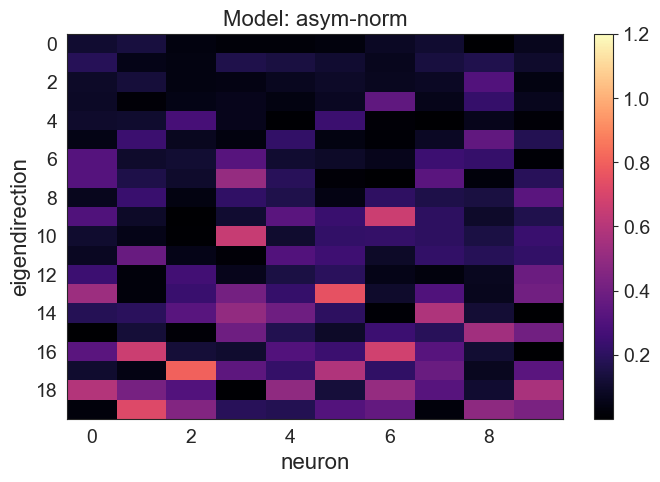

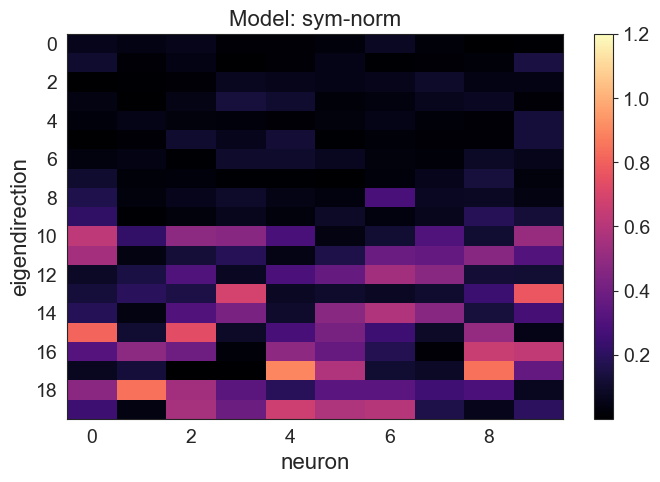

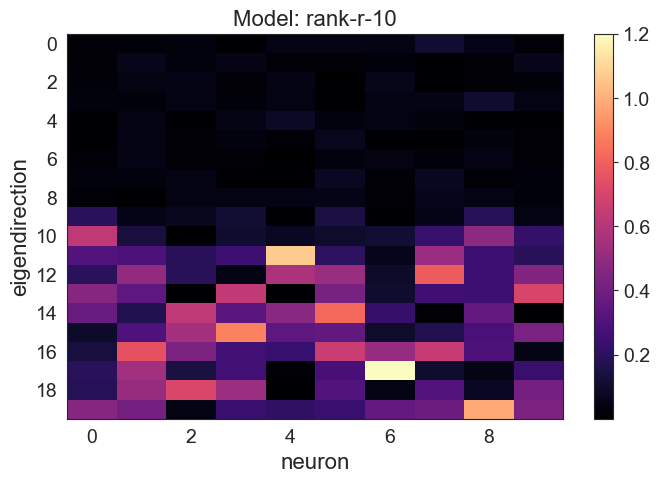

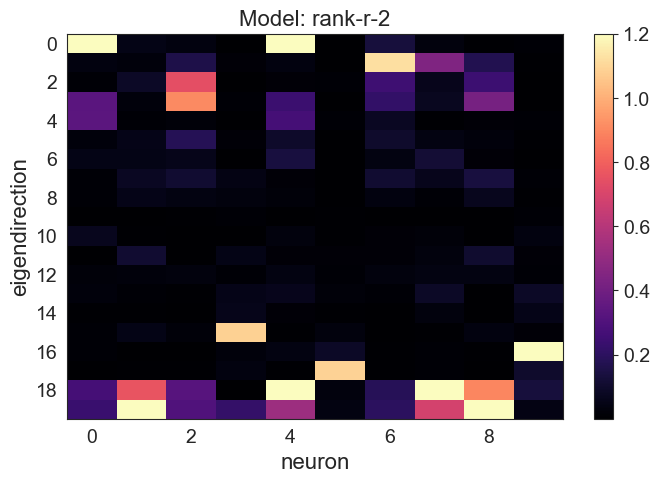

In [153]:
for model, model_name in zip(models[:-2], model_names[:-2]):
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(8, 5))
    
    # Get eigenvectors of Wn for this model
    _eigvals, U = t.linalg.eigh(model.Wn.squeeze())  # **NOTE: Wn not perfectly symmetric...
    
    # Compute dot-product magnitudes between eigenvectors and output weights
    projs = t.abs(U.T @ model.W2.squeeze())  # [feat, hid] dot-product magnitudes
    
    # Create heatmap on the axis
    im = ax.imshow(asnumpy(projs), aspect="auto", cmap="magma", vmax=1.2)
    
    ax.set_yticks(np.arange(0, 20, 2))
    ax.set_xlabel("neuron")
    ax.set_ylabel("eigendirection")
    ax.set_title(f"Model: {model_name}", fontsize=16)
    cbar = fig.colorbar(im, ax=ax)
    
    # Expectation: higher-value but fewer bright streaks = fewer neurons cover many eigen-directions = effectively lower rank = easier to learn

### p=0.9

#### Performance across feature_probs

#### Input-Output


#### Weights


#### Singular Value spectra of $r(x)$

#### Dot-products of $W_2$ neurons with $W_n$ eigenvectors


Questions:

- What is the optimal noise given a particular model? Can we solve for this analytically?

---

---

## Var explained of PCs of input and output

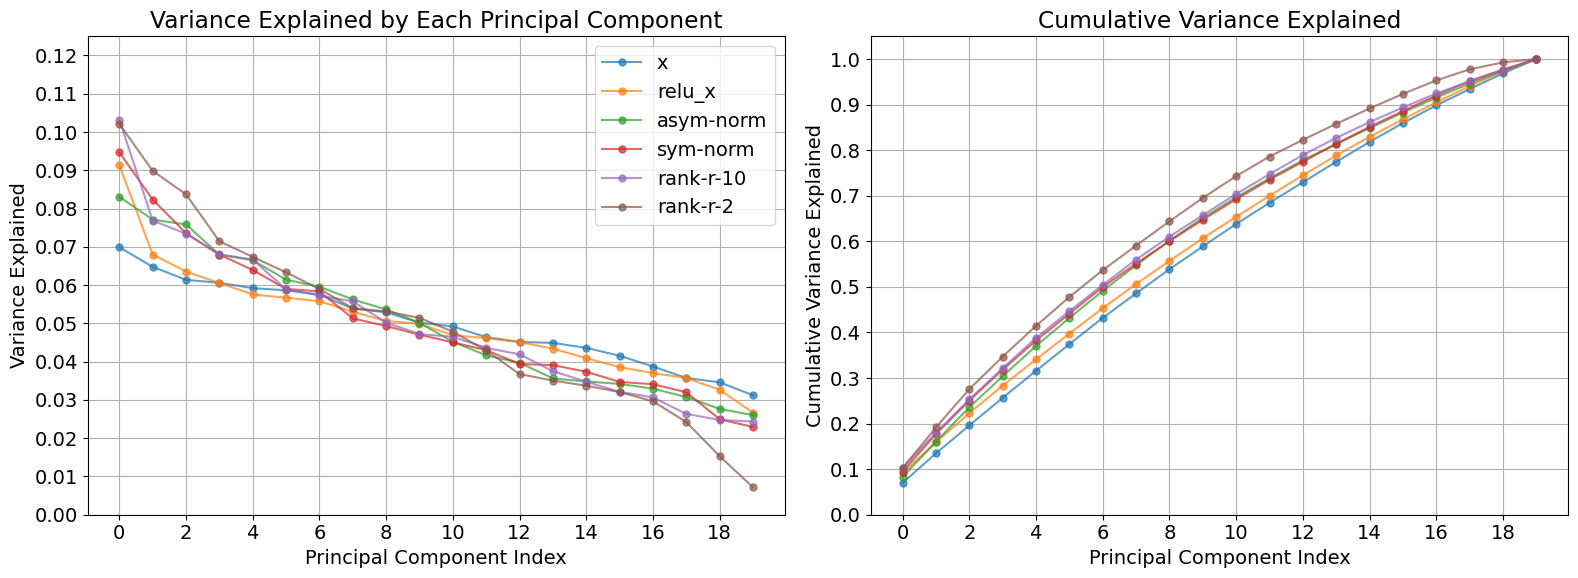

In [ ]:
pc_dict = {}

models = [cis_asym_norm, cis_sym_norm, cis_rr10, cis_rr2]
model_names = ["asym-norm", "sym-norm", "rank-r-10", "rank-r-2"]

x, relu_x = gen_batch(models[0], 1024, feat_sparsity, device)

# Get PC var explained for input
x_sv = t.linalg.svdvals(x.squeeze()).sort(descending=True).values
x_var_explained = (x_sv**2) / (x_sv**2).sum()
pc_dict["x"] = x_var_explained

# Get PC var explained for true output (ReLU)
relu_x_sv = t.linalg.svdvals(relu_x.squeeze()).sort(descending=True).values
relu_x_var_explained = (relu_x_sv**2) / (relu_x_sv**2).sum()
pc_dict["relu_x"] = relu_x_var_explained

# Then loop over models and get PC var explained for predicted outputs
for model, model_name in zip(models, model_names):
    # Get predicted output for this model
    with t.no_grad():
        y_pred = model.forward(x)
    
    # Get PC var explained
    y_sv = t.linalg.svdvals(y_pred.squeeze()).sort(descending=True).values
    y_var_explained = (y_sv**2) / (y_sv**2).sum()
    pc_dict[f"{model_name}"] = y_var_explained

# Create cumulative variance plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Regular variance explained per component
for name, var_explained in pc_dict.items():
    ax1.plot(asnumpy(var_explained), label=name, marker='o', markersize=5, alpha=0.7)

ax1.set_xlabel("Principal Component Index")
ax1.set_ylabel("Variance Explained")
ax1.set_title("Variance Explained by Each Principal Component")
ax1.set_xticks(np.arange(0, 20, 2))
ax1.set_ylim([0, 0.125])
ax1.set_yticks(np.arange(0, 0.125, 0.01))
ax1.legend()
ax1.grid(True)

# Cumulative variance explained
for name, var_explained in pc_dict.items():
    ax2.plot(asnumpy(t.cumsum(var_explained, dim=0)), label=name, marker='o', markersize=5, alpha=0.7)

ax2.set_xlabel("Principal Component Index")
ax2.set_ylabel("Cumulative Variance Explained")
ax2.set_title("Cumulative Variance Explained")
ax2.set_yticks(np.arange(0, 1.05, 0.1))
ax2.set_ylim([0, 1.05])
ax2.set_xticks(np.arange(0, 20, 2))
ax2.legend()
ax2.grid(True)

# Add a horizontal line at 0.9 (90% variance explained)
# ax2.axhline(y=0.9, color='gray', linestyle='--', alpha=0.7)
# ax2.text(0, 0.91, '90% variance', fontsize=10, color='gray')

# plt.tight_layout()
# plt.show()

# # Print the number of PCs needed to explain 90% of variance
# print("Number of PCs needed to explain 90% of variance:")
# for name, var_explained in pc_dict.items():
#     cumulative = t.cumsum(var_explained)
#     n_pcs = t.sum(cumulative < 0.9) + 1  # +1 because we need to include the component that crosses 0.9
#     label = "Input" if name == "input" else "True Output" if name == "true_output" else f"Pred: {name[5:]}"
#     print(f"  {label}: {n_pcs.item()} PCs")

In [ ]:
# Create dictionaries to store variance explained data
output_pc_dict = {}  # For model outputs
noise_pc_dict = {}   # For noise matrices

models = [cis_asym_norm, cis_sym_norm, cis_rr10, cis_rr2]
model_names = ["asym-norm", "sym-norm", "rank-r-10", "rank-r-2"]

x, relu_x = gen_batch(models[0], 1024, feat_sparsity, device)

# Get PC var explained for true output (ReLU)
relu_x_sv = t.linalg.svdvals(relu_x.squeeze()).sort(descending=True).values
relu_x_var_explained = (relu_x_sv**2) / (relu_x_sv**2).sum()
output_pc_dict["relu_x"] = relu_x_var_explained

# Loop over models to get both output and noise matrix PC variance explained
for model, model_name in zip(models, model_names):
    # 1. Get predicted output for this model and its variance explained
    with t.no_grad():
        y_pred = model.forward(x)
    
    y_sv = t.linalg.svdvals(y_pred.squeeze()).sort(descending=True).values
    y_var_explained = (y_sv**2) / (y_sv**2).sum()
    output_pc_dict[f"{model_name}"] = y_var_explained
    
    # 2. Get noise matrix (Wn) variance explained
    wn_sv = t.linalg.svdvals(model.Wn.squeeze()).sort(descending=True).values
    wn_var_explained = (wn_sv**2) / (wn_sv**2).sum()
    noise_pc_dict[f"{model_name}"] = wn_var_explained

# Create cumulative variance plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Cumulative variance explained for model outputs (true and predicted)
ax1.plot(asnumpy(t.cumsum(output_pc_dict["relu_x"], dim=0)), 
         label="True ReLU", marker='o', markersize=5, alpha=0.7, linewidth=2)

for model_name in model_names:
    var_explained = output_pc_dict[model_name]
    ax1.plot(asnumpy(t.cumsum(var_explained, dim=0)), 
             label=f"Pred: {model_name}", marker='o', markersize=5, alpha=0.7)

ax1.set_xlabel("Principal Component Index")
ax1.set_ylabel("Cumulative Variance Explained")
ax1.set_title("Cumulative Variance Explained: Model Outputs")
ax1.set_yticks(np.arange(0, 1.05, 0.1))
ax1.set_ylim([0, 1.05])
ax1.set_xticks(np.arange(0, 20, 2))
ax1.legend()
ax1.grid(True)

# # Right plot: Cumulative variance explained for noise matrices (Wn)
# for model_name in model_names:
#     var_explained = noise_pc_dict[model_name]
#     ax2.plot(asnumpy(t.cumsum(var_explained, dim=0)), 
#              label=f"Noise: {model_name}", marker='o', markersize=5, alpha=0.7)

# ax2.set_xlabel("Principal Component Index")
# ax2.set_ylabel("Cumulative Variance Explained")
# ax2.set_title("Cumulative Variance Explained: Noise Matrices")
# ax2.set_yticks(np.arange(0, 1.05, 0.1))
# ax2.set_ylim([0, 1.05])
# ax2.set_xticks(np.arange(0, 20, 2))
# ax2.legend()
# ax2.grid(True)

# plt.tight_layout()

# # Optionally add horizontal reference lines at 0.9 (90% variance explained)
# ax1.axhline(y=0.9, color='gray', linestyle='--', alpha=0.5)
# ax2.axhline(y=0.9, color='gray', linestyle='--', alpha=0.5)



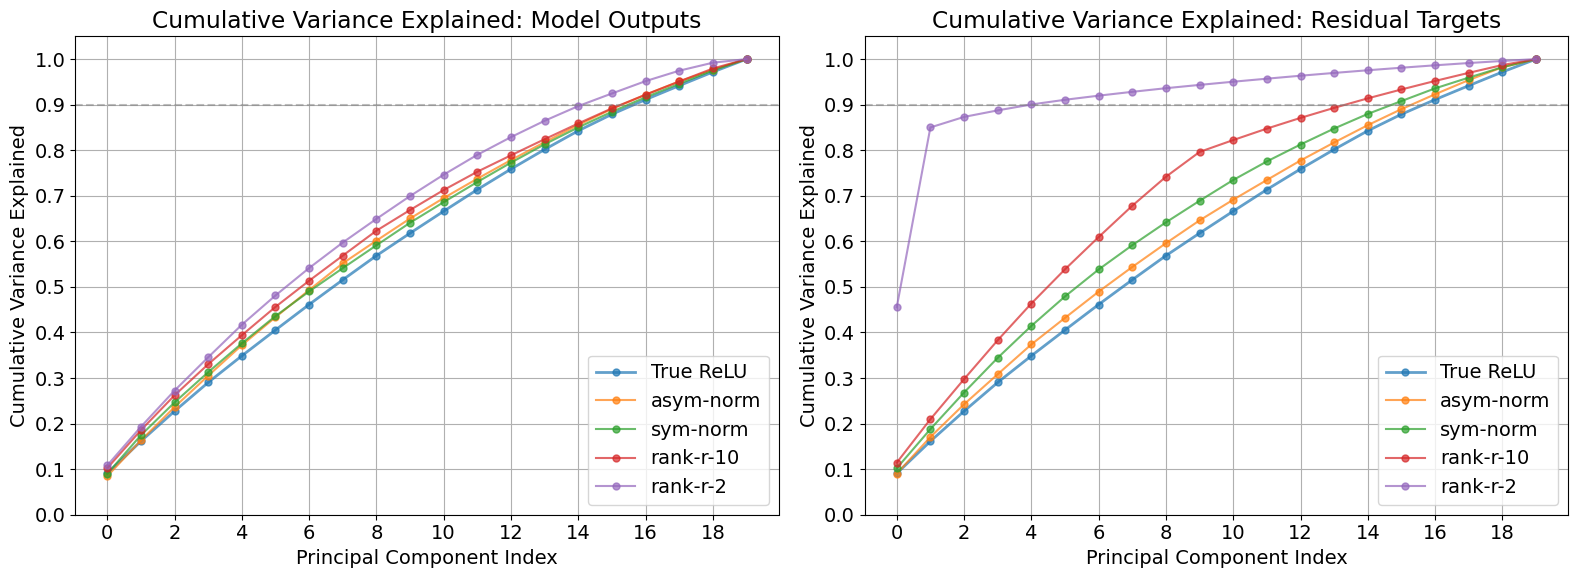

In [31]:
# Create dictionaries to store variance explained data
output_pc_dict = {}  # For model outputs
residual_pc_dict = {}  # For residual targets (relu_x - Wnx)

models = [cis_asym_norm, cis_sym_norm, cis_rr10, cis_rr2]
model_names = ["asym-norm", "sym-norm", "rank-r-10", "rank-r-2"]

x, relu_x = gen_batch(models[0], 1024, feat_sparsity, device)

# Get PC var explained for true output (ReLU)
relu_x_sv = t.linalg.svdvals(relu_x.squeeze()).sort(descending=True).values
relu_x_var_explained = (relu_x_sv**2) / (relu_x_sv**2).sum()
output_pc_dict["relu_x"] = relu_x_var_explained

# Loop over models to get both output and residual target PC variance explained
for model, model_name in zip(models, model_names):
    # 1. Get predicted output for this model and its variance explained
    with t.no_grad():
        y_pred = model.forward(x)
    
    y_sv = t.linalg.svdvals(y_pred.squeeze()).sort(descending=True).values
    y_var_explained = (y_sv**2) / (y_sv**2).sum()
    output_pc_dict[f"{model_name}"] = y_var_explained
    
    # 2. Get residual target (what needs to be learned by W1→W2 path)
    Wnx = einsum(model.Wn, x, "inst feat feat_out, batch inst feat -> batch inst feat_out")
    res_target = relu_x - Wnx
    
    # Calculate variance explained by PCs of residual target
    res_sv = t.linalg.svdvals(res_target.squeeze()).sort(descending=True).values
    res_var_explained = (res_sv**2) / (res_sv**2).sum()
    residual_pc_dict[f"{model_name}"] = res_var_explained

# Create cumulative variance plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Cumulative variance explained for model outputs (true and predicted)
ax1.plot(asnumpy(t.cumsum(output_pc_dict["relu_x"], dim=0)), 
         label="True ReLU", marker='o', markersize=5, alpha=0.7, linewidth=2)

for model_name in model_names:
    var_explained = output_pc_dict[model_name]
    ax1.plot(asnumpy(t.cumsum(var_explained, dim=0)), 
             label=f"{model_name}", marker='o', markersize=5, alpha=0.7)

ax1.set_xlabel("Principal Component Index")
ax1.set_ylabel("Cumulative Variance Explained")
ax1.set_title("Cumulative Variance Explained: Model Outputs")
ax1.set_yticks(np.arange(0, 1.05, 0.1))
ax1.set_ylim([0, 1.05])
ax1.set_xticks(np.arange(0, 20, 2))
ax1.legend()
ax1.grid(True)

ax2.plot(asnumpy(t.cumsum(output_pc_dict["relu_x"], dim=0)), 
         label="True ReLU", marker='o', markersize=5, alpha=0.7, linewidth=2)

# Right plot: Cumulative variance explained for residual targets (relu_x - Wnx)
for model_name in model_names:
    var_explained = residual_pc_dict[model_name]
    ax2.plot(asnumpy(t.cumsum(var_explained, dim=0)), 
             label=f"{model_name}", marker='o', markersize=5, alpha=0.7)

ax2.set_xlabel("Principal Component Index")
ax2.set_ylabel("Cumulative Variance Explained")
ax2.set_title("Cumulative Variance Explained: Residual Targets")
ax2.set_yticks(np.arange(0, 1.05, 0.1))
ax2.set_ylim([0, 1.05])
ax2.set_xticks(np.arange(0, 20, 2))
ax2.legend()
ax2.grid(True)

plt.tight_layout()

# Optionally add horizontal reference lines at 0.9 (90% variance explained)
ax1.axhline(y=0.9, color='gray', linestyle='--', alpha=0.5)
ax2.axhline(y=0.9, color='gray', linestyle='--', alpha=0.5)

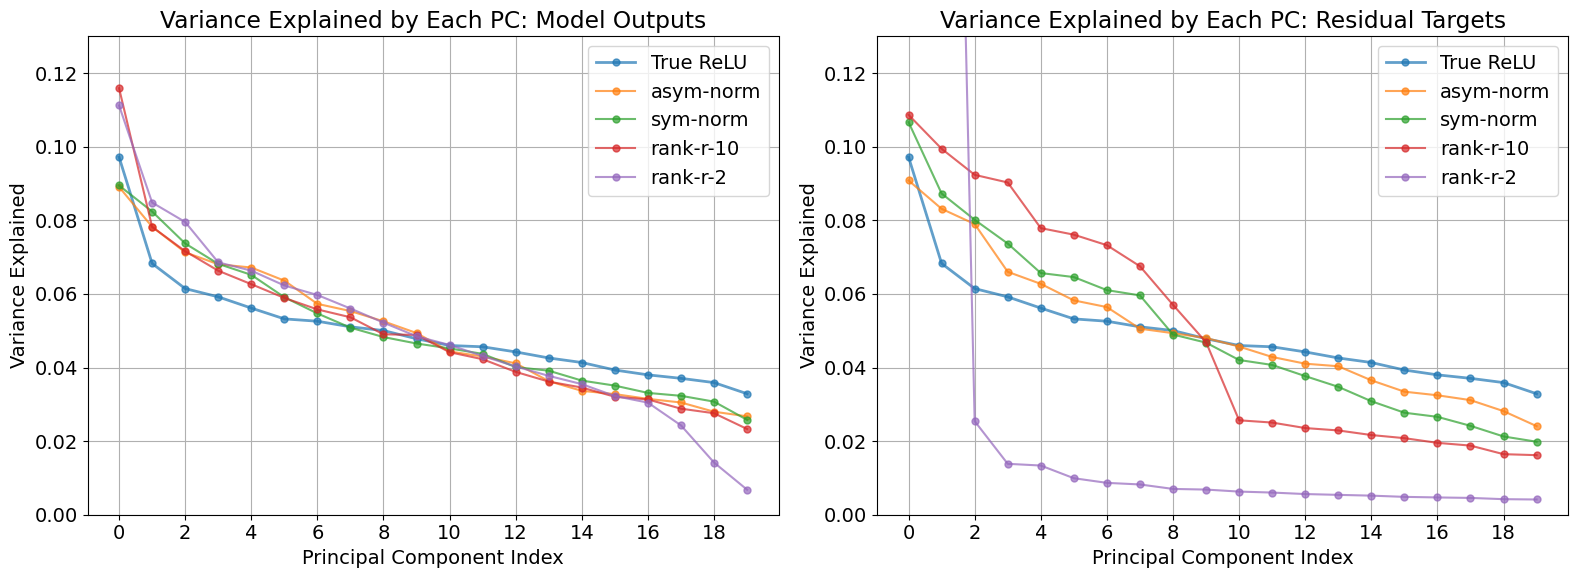

In [34]:
# Create dictionaries to store variance explained data
output_pc_dict = {}  # For model outputs
residual_pc_dict = {}  # For residual targets (relu_x - Wnx)

models = [cis_asym_norm, cis_sym_norm, cis_rr10, cis_rr2]
model_names = ["asym-norm", "sym-norm", "rank-r-10", "rank-r-2"]

x, relu_x = gen_batch(models[0], 1024, feat_sparsity, device)

# Get PC var explained for true output (ReLU)
relu_x_sv = t.linalg.svdvals(relu_x.squeeze()).sort(descending=True).values
relu_x_var_explained = (relu_x_sv**2) / (relu_x_sv**2).sum()
output_pc_dict["relu_x"] = relu_x_var_explained

# Loop over models to get both output and residual target PC variance explained
for model, model_name in zip(models, model_names):
    # 1. Get predicted output for this model and its variance explained
    with t.no_grad():
        y_pred = model.forward(x)
    
    y_sv = t.linalg.svdvals(y_pred.squeeze()).sort(descending=True).values
    y_var_explained = (y_sv**2) / (y_sv**2).sum()
    output_pc_dict[f"{model_name}"] = y_var_explained
    
    # 2. Get residual target (what needs to be learned by W1→W2 path)
    Wnx = einsum(model.Wn, x, "inst feat feat_out, batch inst feat -> batch inst feat_out")
    res_target = relu_x - Wnx
    
    # Calculate variance explained by PCs of residual target
    res_sv = t.linalg.svdvals(res_target.squeeze()).sort(descending=True).values
    res_var_explained = (res_sv**2) / (res_sv**2).sum()
    residual_pc_dict[f"{model_name}"] = res_var_explained

# Create non-cumulative variance plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Non-cumulative variance explained for model outputs (true and predicted)
ax1.plot(asnumpy(output_pc_dict["relu_x"]), 
         label="True ReLU", marker='o', markersize=5, alpha=0.7, linewidth=2)

for model_name in model_names:
    var_explained = output_pc_dict[model_name]
    ax1.plot(asnumpy(var_explained), 
             label=f"{model_name}", marker='o', markersize=5, alpha=0.7)

ax1.set_xlabel("Principal Component Index")
ax1.set_ylabel("Variance Explained")
ax1.set_title("Variance Explained by Each PC: Model Outputs")
ax1.set_xticks(np.arange(0, 20, 2))
ax1.set_ylim([0, 0.13])  # Adjust based on your data
ax1.legend()
ax1.grid(True)

# Right plot: Non-cumulative variance explained for residual targets (relu_x - Wnx)
ax2.plot(asnumpy(output_pc_dict["relu_x"]), 
         label="True ReLU", marker='o', markersize=5, alpha=0.7, linewidth=2)

for model_name in model_names:
    var_explained = residual_pc_dict[model_name]
    ax2.plot(asnumpy(var_explained), 
             label=f"{model_name}", marker='o', markersize=5, alpha=0.7)

ax2.set_xlabel("Principal Component Index")
ax2.set_ylabel("Variance Explained")
ax2.set_title("Variance Explained by Each PC: Residual Targets")
ax2.set_xticks(np.arange(0, 20, 2))
ax2.set_ylim([0, 0.13])  # Adjust based on your data
ax2.legend()
ax2.grid(True)

plt.tight_layout()

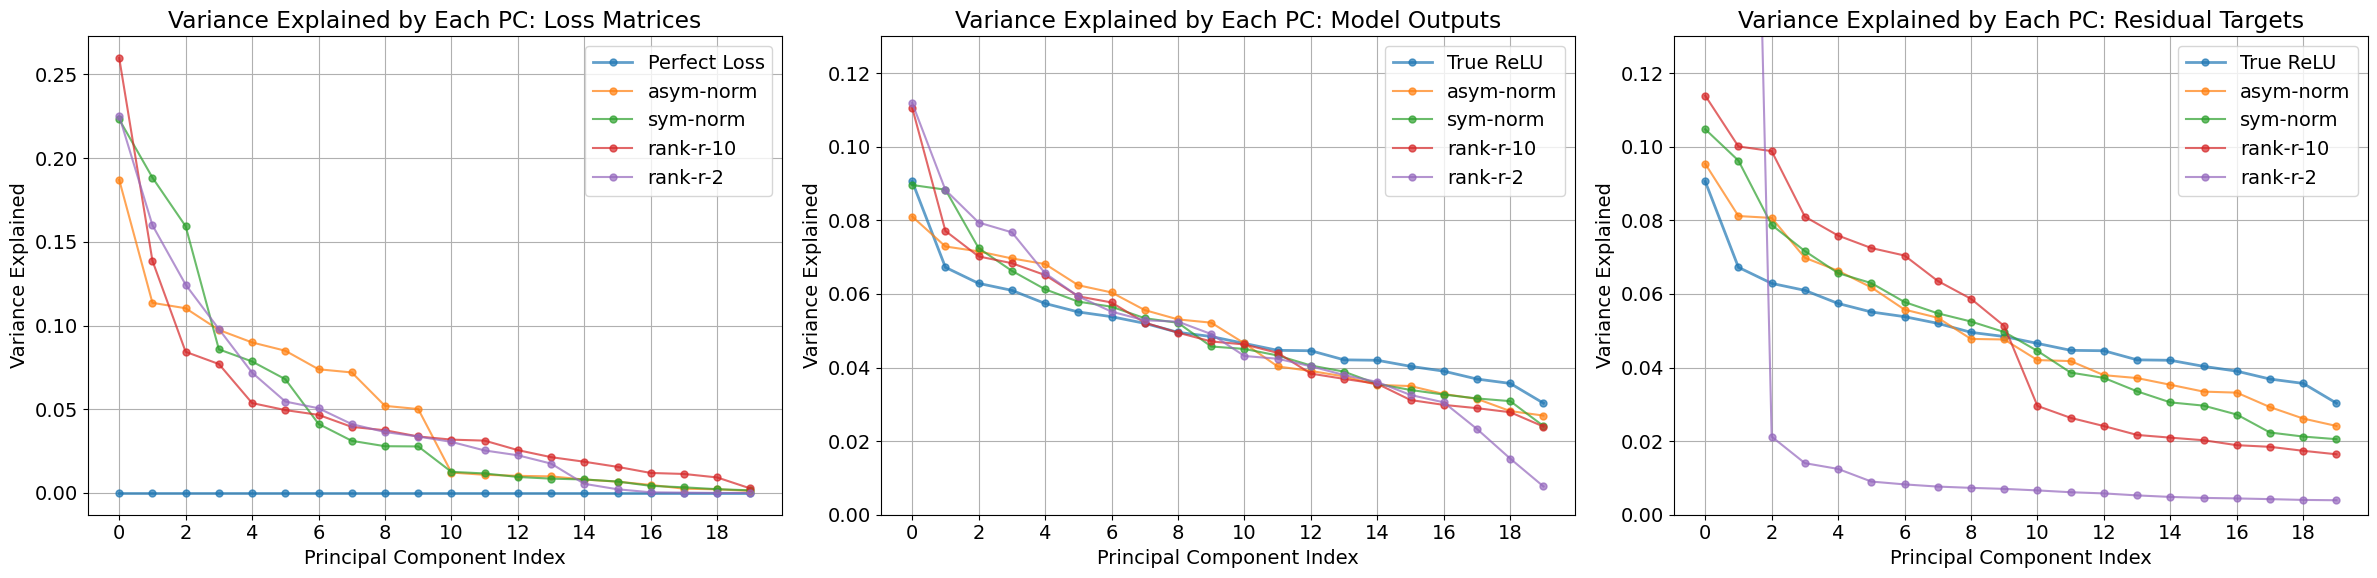

In [36]:
# Create dictionaries to store variance explained data
output_pc_dict = {}     # For model outputs
residual_pc_dict = {}   # For residual targets (relu_x - Wnx)
loss_pc_dict = {}       # For loss matrices (MSE between true and predicted)

models = [cis_asym_norm, cis_sym_norm, cis_rr10, cis_rr2]
model_names = ["asym-norm", "sym-norm", "rank-r-10", "rank-r-2"]

x, relu_x = gen_batch(models[0], 1024, feat_sparsity, device)

# Get PC var explained for true output (ReLU)
relu_x_sv = t.linalg.svdvals(relu_x.squeeze()).sort(descending=True).values
relu_x_var_explained = (relu_x_sv**2) / (relu_x_sv**2).sum()
output_pc_dict["relu_x"] = relu_x_var_explained

# Create a "perfect loss" placeholder for consistent color scheme
loss_pc_dict["perfect"] = t.zeros_like(relu_x_var_explained)

# Loop over models to get variance explained for outputs, residuals, and loss
for model, model_name in zip(models, model_names):
    # 1. Get predicted output for this model
    with t.no_grad():
        y_pred = model.forward(x)
    
    # 2. Calculate variance explained by PCs of model output
    y_sv = t.linalg.svdvals(y_pred.squeeze()).sort(descending=True).values
    y_var_explained = (y_sv**2) / (y_sv**2).sum()
    output_pc_dict[f"{model_name}"] = y_var_explained
    
    # 3. Get residual target (what needs to be learned by W1→W2 path)
    Wnx = einsum(model.Wn, x, "inst feat feat_out, batch inst feat -> batch inst feat_out")
    res_target = relu_x - Wnx
    
    # 4. Calculate variance explained by PCs of residual target
    res_sv = t.linalg.svdvals(res_target.squeeze()).sort(descending=True).values
    res_var_explained = (res_sv**2) / (res_sv**2).sum()
    residual_pc_dict[f"{model_name}"] = res_var_explained
    
    # 5. Calculate MSE loss matrix and its PC variance explained
    loss_matrix = (relu_x - y_pred)**2
    loss_sv = t.linalg.svdvals(loss_matrix.squeeze()).sort(descending=True).values
    loss_var_explained = (loss_sv**2) / (loss_sv**2).sum()
    loss_pc_dict[f"{model_name}"] = loss_var_explained

# Create non-cumulative variance plots in a 1x3 grid
fig, (ax_loss, ax_output, ax_residual) = plt.subplots(1, 3, figsize=(24, 6))

# Left plot: Non-cumulative variance explained for loss matrices
ax_loss.plot(asnumpy(loss_pc_dict["perfect"]), 
         label="Perfect Loss", marker='o', markersize=5, alpha=0.7, linewidth=2)

for model_name in model_names:
    var_explained = loss_pc_dict[model_name]
    ax_loss.plot(asnumpy(var_explained), 
             label=f"{model_name}", marker='o', markersize=5, alpha=0.7)

ax_loss.set_xlabel("Principal Component Index")
ax_loss.set_ylabel("Variance Explained")
ax_loss.set_title("Variance Explained by Each PC: Loss Matrices")
ax_loss.set_xticks(np.arange(0, 20, 2))
# ax_loss.set_ylim([0, 0.13])
ax_loss.legend()
ax_loss.grid(True)

# Middle plot: Non-cumulative variance explained for model outputs
ax_output.plot(asnumpy(output_pc_dict["relu_x"]), 
         label="True ReLU", marker='o', markersize=5, alpha=0.7, linewidth=2)

for model_name in model_names:
    var_explained = output_pc_dict[model_name]
    ax_output.plot(asnumpy(var_explained), 
             label=f"{model_name}", marker='o', markersize=5, alpha=0.7)

ax_output.set_xlabel("Principal Component Index")
ax_output.set_ylabel("Variance Explained")
ax_output.set_title("Variance Explained by Each PC: Model Outputs")
ax_output.set_xticks(np.arange(0, 20, 2))
ax_output.set_ylim([0, 0.13])
ax_output.legend()
ax_output.grid(True)

# Right plot: Non-cumulative variance explained for residual targets
ax_residual.plot(asnumpy(output_pc_dict["relu_x"]), 
         label="True ReLU", marker='o', markersize=5, alpha=0.7, linewidth=2)

for model_name in model_names:
    var_explained = residual_pc_dict[model_name]
    ax_residual.plot(asnumpy(var_explained), 
             label=f"{model_name}", marker='o', markersize=5, alpha=0.7)

ax_residual.set_xlabel("Principal Component Index")
ax_residual.set_ylabel("Variance Explained")
ax_residual.set_title("Variance Explained by Each PC: Residual Targets")
ax_residual.set_xticks(np.arange(0, 20, 2))
ax_residual.set_ylim([0, 0.13])
ax_residual.legend()
ax_residual.grid(True)

plt.tight_layout()